In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm
import math

In [2]:
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.reward import RewardBase
from amalearn.environment import EnvironmentBase
from amalearn.reward import GaussianReward
from amalearn.agent import RandomBanditAgent
from amalearn.agent import AgentBase

## Utils

In [3]:
def calculate_action_percentage(chosen_actions, window = 1000):
    result = []
    for j in tqdm(range(11)):
        temp = []
        for i in range(len(chosen_actions) - window):
            temp.append(chosen_actions[i:i+window].count(j)/window*100)
        result.append(temp)
    return result

## Class definitions

In [4]:
class MyQ2Reward(RewardBase):
    def __init__(self):
        super(MyQ2Reward, self).__init__()

    def get_reward_prime(self, action):
        reward = None
        wait = int(np.random.normal(6, 4, 1))
        if wait < 0: wait = 0
        if wait <= action:
            reward = 0.7 * (10 - wait) - 0.2 * wait
        else:
            reward = ( 0.7 * (10 - action) - 0.2 * action ) * 0.5
        return 4 ** reward
    
    def get_reward_2(self, action):
        reward = None
        wait = int(np.random.normal(6, 4, 1))
        if wait < 0: wait = 0
        if wait <= action:
            reward = 0.7 * (10 - wait) - 0.2 * wait
        else:
            reward = ( 0.7 * (10 - action) - 0.2 * action ) * 0.3
        return 10 * reward

    def get_reward_(self, action):
        reward = None
        wait = int(np.random.normal(6, 4, 1))
        if wait < 0: wait = 0
        if wait <= action:
            reward = (10 - wait) * 3 - wait * 4
        else:
            reward = ((10 - action) * 3 - action * 4 )
            if reward > 0:
                reward ** (1/4)
        return reward / 10
    
    def get_reward(self, action):
        reward = None
        wait = int(np.random.normal(6, 4, 1))
        if wait < 0: wait = 0
        if wait <= action:
            reward = (10 - wait) * 16 - wait * 12
        else:
            reward = ((10 - action) * 16 - action * 12 ) * 0.2
        if action == 0:
            reward -= 1.5
        if action == 0:
            reward -= 1
        return reward / 10

In [5]:
class myQ2Environment(EnvironmentBase):
    def __init__(self, rewards, num_of_actions, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(num_of_actions)
        
        super(myQ2Environment, self).__init__(action_space, state_space, id, container)
        self.rewards = rewards
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def calculate_reward(self, action):
        return self.rewards.get_reward(action)
    
    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

In [6]:
class eGreedyAgent(AgentBase):
    def __init__(self, id, num_of_actions, environment):
        super(eGreedyAgent, self).__init__(id, environment)
        self.trial = 0
        self.actions = np.zeros(num_of_actions)
        self.action_num = np.ones(num_of_actions)
        self.rev = np.zeros(num_of_actions)
        
    def hemographic_learning_rate(self, x):
        return 100/((0.005)*x+400)
    
    def get_epsilo(self, x):
        return (2 ** (1 - 0.0001 * x)) / 2
    
    def get_action(self, available_actions, epsilon):
        if self.trial == 1:
            return np.random.randint(available_actions)
        if np.random.rand() > epsilon:
            return np.argmax(self.actions)
        else:
            return np.random.randint(available_actions)
        
    def get_actions(self):
        return self.actions, self.action_num, self.rev
    
    def take_action(self) -> (object, float, bool, object):
        
        self.trial += 1
        epsilon = self.get_epsilo(self.trial)
        
        available_actions = self.environment.available_actions()
        action = self.get_action(available_actions, epsilon)
        self.action_num[action] += 1
        
        obs, reward, fin, info = self.environment.step(action)
        
        learning_rate = 1/(1+self.action_num[action])
        self.rev[action] = self.rev[action] + reward
        self.actions[action] = self.actions[action] + learning_rate * (reward - self.actions[action])

        if fin: print('-----Terminated-----')
        return reward, fin, action

In [7]:
class UCBAgent(AgentBase):
    def __init__(self, id, num_of_actions, environment):
        super(eGreedyAgent, self).__init__(id, environment)
        self.trial = 0
        self.counts = np.zeros(num_of_actions)
        self.q_values = np.ones(num_of_actions)
        
    def hemographic_learning_rate(self, x):
        return 100/((0.005)*x+100)
    
    def get_action(self, available_actions):
        for arm in range(available_actions):
            if self.counts[arm] == 0:
                return arm
        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts = sum(self.counts)
        
        for arm in range(available_actions):
            bonus = math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
            ucb_values[arm] = self.q_values[arm] + bonus
        return np.argmax(ucb_values)
        
    def get_actions(self):
        return self.actions, self.action_num, self.rev
    
    def take_action(self) -> (object, float, bool, object):
        
        self.trial += 1
        print('Trial:', self.trial)
        
        available_actions = self.environment.available_actions()
        action = self.get_action(available_actions)
        self.counts[action] += 1
        
        obs, reward, fin, info = self.environment.step(action)
        
        learning_rate = self.hemographic_learning_rate(self.counts[action])
        n = self.counts[action]
        value = self.q_values[action]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward * learning_rate
        self.q_values[action] = new_value

        if fin: print('-----Terminated-----')
        return reward, fin, action

## Learn

### E-Greedy

In [8]:
rewards = MyQ2Reward()
environment = myQ2Environment(rewards, 11, 100000, '1')
egreedyAgent = eGreedyAgent('2', 11, environment)

In [9]:
result_e_greedy_agent = []
for step in range(100000):
    result_e_greedy_agent.append(egreedyAgent.take_action())

-----Terminated-----


In [10]:
chosen_actions = [i[2] for i in result_e_greedy_agent]
rewards_actions = [i[0] for i in result_e_greedy_agent]

optimal_percentage_e = calculate_action_percentage(chosen_actions)

100%|██████████| 11/11 [02:59<00:00, 16.31s/it]


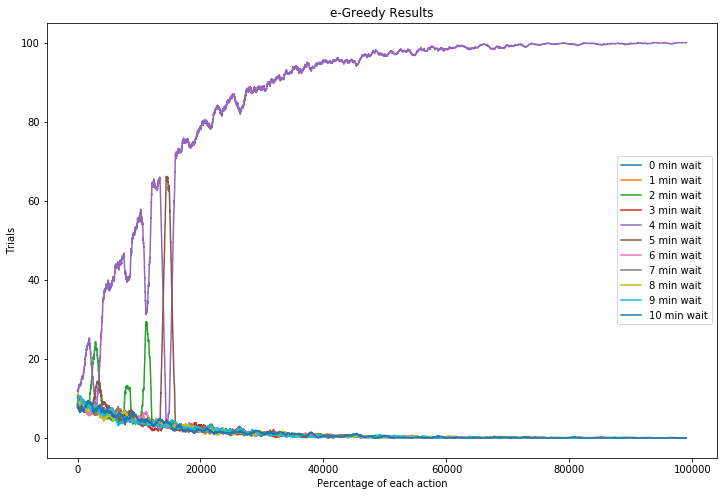

In [11]:
plt.figure(figsize=(12, 8))
for i in range(0, 11):
    plt.plot(range(len(optimal_percentage_e[i])), optimal_percentage_e[i], label= str(i) + " min wait")
plt.legend(loc="center right")
plt.title('e-Greedy Results')
plt.xlabel('Percentage of each action')
plt.ylabel('Trials')
plt.show()

### UCB

In [12]:
rewards = MyQ2Reward()
environment = myQ2Environment(rewards, 11, 100000, '1')
ucbAgent = eGreedyAgent('2', 11, environment)

In [13]:
result_ucb_agent = []
for step in range(100000):
    result_ucb_agent.append(ucbAgent.take_action())

-----Terminated-----


In [14]:
chosen_actions_ubc = [i[2] for i in result_ucb_agent]
rewards_actions_ubc = [i[0] for i in result_ucb_agent]

optimal_percentage_ubc = calculate_action_percentage(chosen_actions_ubc)

100%|██████████| 11/11 [02:57<00:00, 16.11s/it]


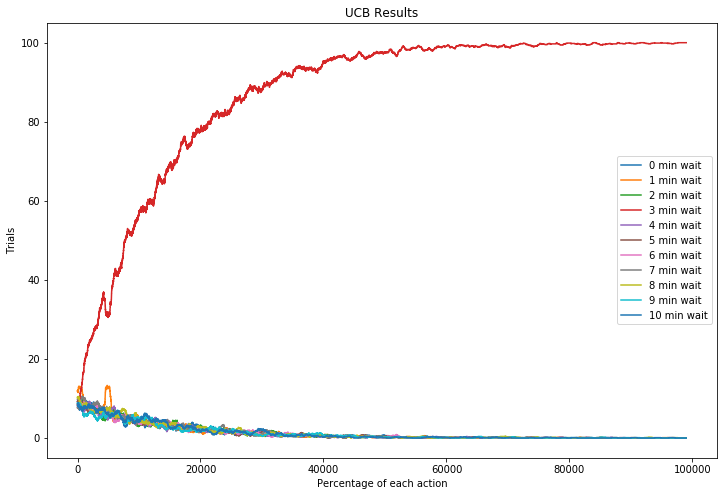

In [15]:
plt.figure(figsize=(12, 8))
for i in range(0, 11):
    plt.plot(range(len(optimal_percentage_ubc[i])), optimal_percentage_ubc[i], label= str(i) + " min wait")
plt.legend(loc="center right")
plt.title('UCB Results')
plt.xlabel('Percentage of each action')
plt.ylabel('Trials')
plt.show()

## More Info

mathematical functions which used as epsilon and learning rate

In [16]:
def hemographic_learning_rate(x):
        return 100/((0.005)*x+300)
    
def get_epsilo(x):
    return (2 ** (1 - 0.0001 * x)) / 2

Text(0.5, 1.0, 'Learning rate')

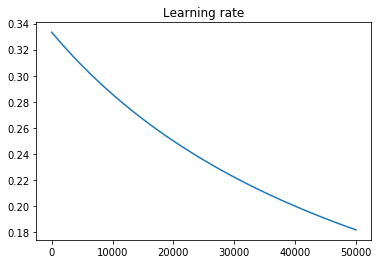

In [17]:
plt.plot(range(50000), [hemographic_learning_rate(i) for i in range(50000)])
plt.title('Learning rate')

Text(0.5, 1.0, 'Epsilon')

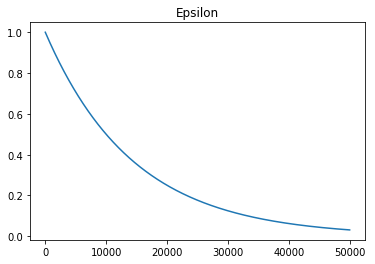

In [18]:
plt.plot(range(50000), [get_epsilo(i) for i in range(50000)])
plt.title('Epsilon')

lets get some samples from each actions reward to aproximate which one is better

In [19]:
def utility(action):
    reward = None
    wait = int(np.random.normal(6, 4, 1))
    if wait < 0: wait = 0
    if wait <= action:
        reward = (10 - wait) * 16 - wait * 12
    else:
        reward = ((10 - action) * 16 - action * 12 ) * 0.2
    return reward / 10

Text(0.5, 1.0, 'Rewards')

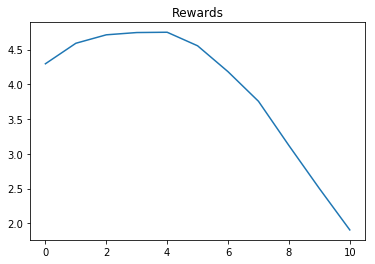

In [20]:
mean_reward_actions = [np.array([utility(action) for i in range(100000)]).mean() for action in range(11)]
plt.plot(range(11), mean_reward_actions)
plt.title('Rewards')